In [3]:
from imblearn.under_sampling import TomekLinks, ClusterCentroids
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
import imblearn
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data

In [4]:
wine = pd.read_csv(
    r"C:\Users\nalla\OneDrive\Desktop\winequality-white.csv", delimiter=";")
print("Data read")

Data read


# EDA

### columns

In [5]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### barplot of the response

barplot


quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

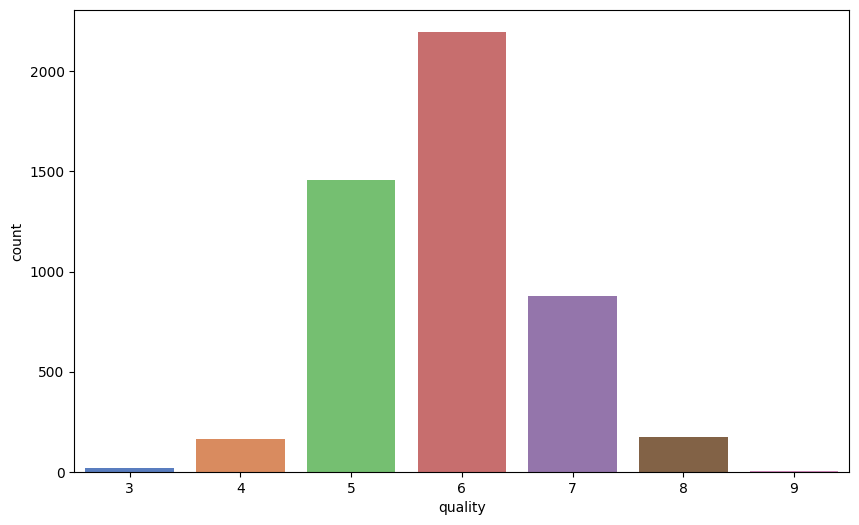

In [7]:
print("barplot")
plt.figure(figsize=(10, 6))
sns.countplot(x=wine["quality"], hue=wine["quality"], palette="muted", legend=False)
wine["quality"].value_counts()

### Data Transformation 

We want to transfer the score(num) to low-medium-high quality level(categorical) by: 

3,4 -> low

5,6 -> medium

7,8,9 -> high

In [11]:
quality = wine["quality"].values
category = []
for num in quality:
    if num < 5:
        category.append("Low")
    elif num > 6:
        category.append("High")
    else:
        category.append("Medium")
[(i, category.count(i)) for i in set(category)]

[('Low', 183), ('High', 1060), ('Medium', 3655)]

### barplot of the response after transformation

C:\Users\nalla\AppData\Local\Temp\ipykernel_32208\345006360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(category, palette="muted")


<Axes: xlabel='count'>

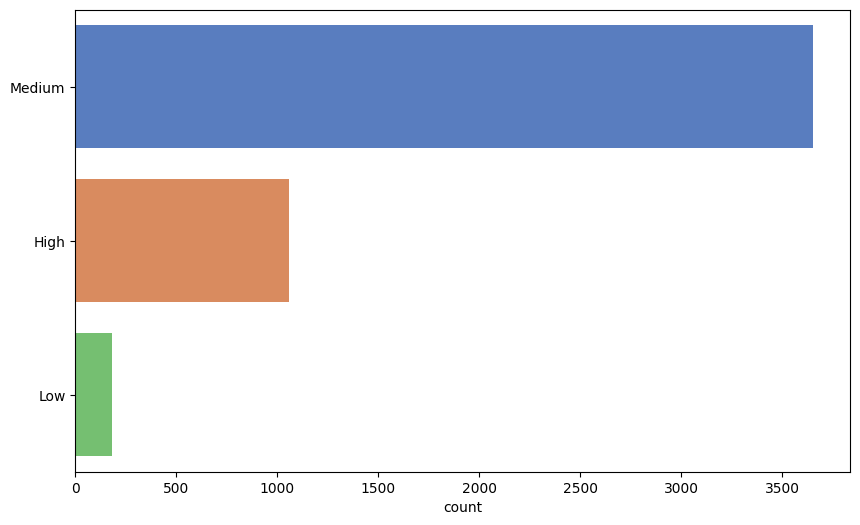

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(category, palette="muted")

### Cor Mat to check features 

<Axes: >

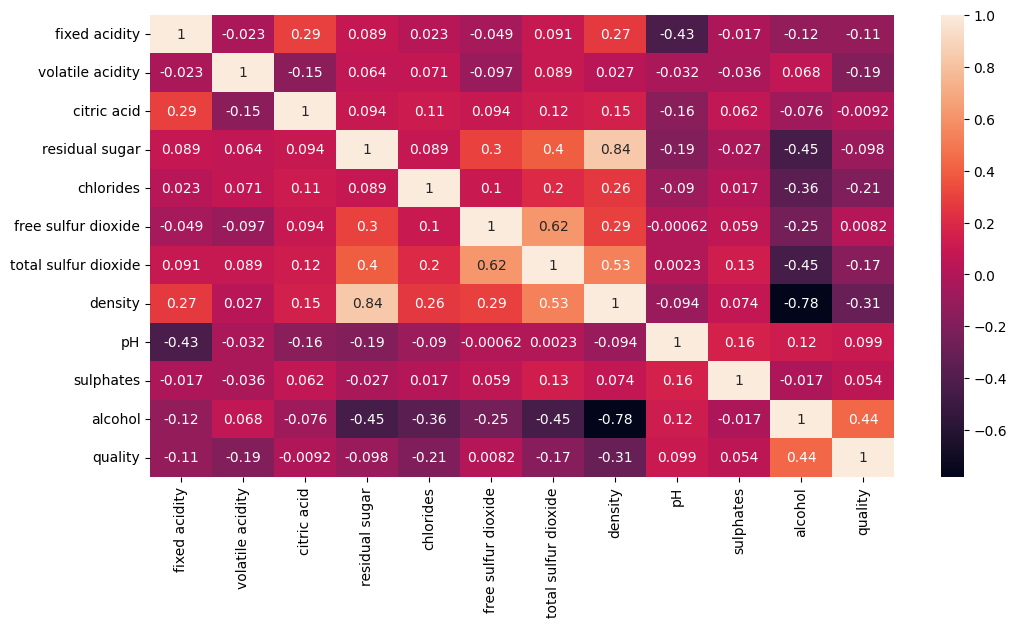

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(wine.corr(), annot=True)

# Set up model matrix

In [14]:
quality = wine["quality"].values
category = []
for num in quality:
    if num < 5:
        category.append("Low")
    elif num > 6:
        category.append("High")
    else:
        category.append("Midium")
category = pd.DataFrame(data=category, columns=["category"])
data = pd.concat([wine, category], axis=1)
data.drop(columns="quality", axis=1, inplace=True)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [15]:
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2018)

# Build models

## random forest

In [17]:
clf = RandomForestClassifier(random_state=2018, oob_score=True)
param_dist = {"n_estimators": [50, 100, 150, 200, 250],
              'min_samples_leaf': [1, 2, 4]}
rfc_gs = GridSearchCV(clf, param_grid=param_dist, scoring='accuracy', cv=5)
rfc_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=2018),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='accuracy')

In [22]:
rfc_gs.best_score_

np.float64(0.8392062188860219)

## SVM

In [23]:
# strtifiedKFold
skf = StratifiedKFold(n_splits=4)

In [24]:
pipe_svm = Pipeline([('clf', svm.SVC())])
grid_params = dict(clf__C=[0.1, 0.3, 1, 3, 10],
                   clf__gamma=[0.1, 0.3, 1, 3, 10],
                   clf__kernel=['rbf', 'sigmoid'])
gs_svm = GridSearchCV(estimator=pipe_svm,
                      param_grid=grid_params,
                      scoring='accuracy',
                      cv=skf)
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clf', SVC())]),
             param_grid={'clf__C': [0.1, 0.3, 1, 3, 10],
                         'clf__gamma': [0.1, 0.3, 1, 3, 10],
                         'clf__kernel': ['rbf', 'sigmoid']},
             scoring='accuracy')

In [25]:
print(gs_svm.best_score_)

0.8083211732088137


In [26]:
# just for comparision
pred_svm = gs_svm.predict(X_test)
print(classification_report(y_test, pred_svm))
print("The SVM model accuracy on Test data is %s" %
      accuracy_score(y_test, pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51       209
           1       1.00      0.06      0.11        35
           2       0.81      1.00      0.90       736

    accuracy                           0.83       980
   macro avg       0.94      0.47      0.51       980
weighted avg       0.86      0.83      0.79       980

The SVM model accuracy on Test data is 0.826530612244898


In [27]:
# relabel back : 0 means good, 1 for low, 2 for medium for better visualization
y_test_re = list(y_test)
for i in range(len(y_test_re)):
    if y_test_re[i] == 0:
        y_test_re[i] = "good"
    if y_test_re[i] == 1:
        y_test_re[i] = "low"
    if y_test_re[i] == 2:
        y_test_re[i] = "medium"
pred_svm_re = list(pred_svm)
for i in range(len(pred_svm_re)):
    if pred_svm_re[i] == 0:
        pred_svm_re[i] = "good"
    if pred_svm_re[i] == 1:
        pred_svm_re[i] = "low"
    if pred_svm_re[i] == 2:
        pred_svm_re[i] = "medium"
y_actu = pd.Series(y_test_re, name='Actual')
y_pred = pd.Series(pred_svm_re, name='Predicted')
svm_confusion = pd.crosstab(y_actu, y_pred)

In [28]:
svm_confusion

Predicted,good,low,medium
Actual,,,
good,72,0,137
low,0,2,33
medium,0,0,736


## Decision Tree

In [29]:
clf = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))])

criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11, 15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None]

param_grid =\
    [{'clf__class_weight': class_weight,
      'clf__criterion': criterion,
      'clf__splitter': splitter,
      'clf__max_depth': max_depth,
      'clf__min_samples_leaf': min_samples_leaf
      }]

gs_dt = GridSearchCV(estimator=clf, param_grid=param_grid,
                     scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__class_weight': ['balanced', None],
                          'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [8, 9, 10, 11, 15, 20, 25],
                          'clf__min_samples_leaf': [2, 3, 5],
                          'clf__splitter': ['best']}],
             scoring='accuracy', verbose=1)

In [30]:
print(gs_dt.best_score_)

0.766726288216436


## KNN

In [31]:
# knn with pca grid search
pipe_knn_pca = Pipeline([('pca', PCA()),
                         ('clf', KNeighborsClassifier())])
grid_params_knn_pca = \
    dict(pca__n_components=range(1, 11), clf__n_neighbors=range(1, 10))

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
                          param_grid=grid_params_knn_pca,
                          scoring='accuracy')

gs_knn_pca.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': range(1, 10),
                         'pca__n_components': range(1, 11)},
             scoring='accuracy')

In [32]:
print(gs_knn_pca.best_score_)

0.7524278676988037


**" Therefore, random Forest gives best result. "**

## check its performance on test

In [33]:
# check its performance on test
pred_rfc = rfc_gs.predict(X_test)
print(classification_report(y_test, pred_rfc))
print("The RF model accuracy on Test data is %s" %
      accuracy_score(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.77      0.62      0.68       209
           1       0.57      0.11      0.19        35
           2       0.86      0.94      0.90       736

    accuracy                           0.84       980
   macro avg       0.73      0.56      0.59       980
weighted avg       0.83      0.84      0.83       980

The RF model accuracy on Test data is 0.8438775510204082


In [36]:
# relabel back : 0 means good, 1 for low, 2 for medium for better visualization
y_test_re = list(y_test)
for i in range(len(y_test_re)):
    if y_test_re[i] == 0:
        y_test_re[i] = "good"
    if y_test_re[i] == 1:
        y_test_re[i] = "low"
    if y_test_re[i] == 2:
        y_test_re[i] = "medium"
pred_rfc_re = list(pred_rfc)
for i in range(len(pred_rfc_re)):
    if pred_rfc_re[i] == 0:
        pred_rfc_re[i] = "good"
    if pred_rfc_re[i] == 1:
        pred_rfc_re[i] = "low"
    if pred_rfc_re[i] == 2:
        pred_rfc_re[i] = "medium"
y_actu = pd.Series(y_test_re, name='Actual')
y_pred = pd.Series(pred_rfc_re, name='Predicted')
rfc_confusion = pd.crosstab(y_actu, y_pred)

In [37]:
rfc_confusion

Predicted,good,low,medium
Actual,,,
good,129,0,80
low,0,4,31
medium,39,3,694


# Resampling 

In [41]:
# under sample "2" ；
# over sample "1", "0"
smt = ClusterCentroids(sampling_strategy={2: 1500})
X_sm, y_sm = smt.fit_resample(X_train, y_train)
smt2 = SMOTE(sampling_strategy={0: 1500, 1: 1500})
X_sm2, y_sm2 = smt2.fit_resample(X_sm, y_sm)

## Random Forest

In [42]:
rfc_rs = RandomForestClassifier(random_state=2018)
param_dist = {"n_estimators": [50, 100, 150, 200, 250],
              'min_samples_leaf': [1, 2, 4]}
rfc_gs_rs = GridSearchCV(rfc_rs, param_grid=param_dist,
                         scoring='accuracy', cv=5)
rfc_gs_rs.fit(X_sm2, y_sm2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2018),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='accuracy')

In [44]:
rfc_gs_rs.best_score_

np.float64(0.8553333333333335)

In [45]:
importances = rfc_gs_rs.best_estimator_.feature_importances_

In [46]:
wine.columns[:-1]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [47]:
feature_importances = pd.DataFrame(importances,index = wine.columns[:-1],
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

<Axes: >

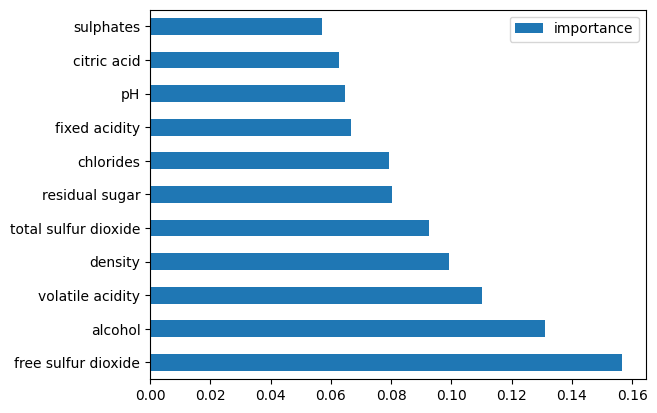

In [48]:
feature_importances.plot(kind='barh')

## SVM_rs

In [49]:
# grid search after resample
pipe_svm = Pipeline([('clf', svm.SVC())])
grid_params = dict(clf__C=[0.1, 0.3, 1, 3, 10],
                   clf__gamma=[0.1, 0.3, 1, 3, 10],
                   clf__kernel=['rbf', 'sigmoid'])
gs_svm_sm = GridSearchCV(estimator=pipe_svm,
                         param_grid=grid_params,
                         scoring='accuracy',
                         cv=skf)
gs_svm_sm.fit(X_sm2, y_sm2)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clf', SVC())]),
             param_grid={'clf__C': [0.1, 0.3, 1, 3, 10],
                         'clf__gamma': [0.1, 0.3, 1, 3, 10],
                         'clf__kernel': ['rbf', 'sigmoid']},
             scoring='accuracy')

In [50]:
gs_svm_sm.best_score_

np.float64(0.8224444444444445)

## DT_rs

In [51]:
clf = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))])

criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11, 15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None]

param_grid =\
    [{'clf__class_weight': class_weight,
      'clf__criterion': criterion,
      'clf__splitter': splitter,
      'clf__max_depth': max_depth,
      'clf__min_samples_leaf': min_samples_leaf
      }]

gs_dt_rs = GridSearchCV(estimator=clf,
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=5,
                        verbose=1,
                        n_jobs=-1)
gs_dt_rs.fit(X_sm2, y_sm2)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__class_weight': ['balanced', None],
                          'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [8, 9, 10, 11, 15, 20, 25],
                          'clf__min_samples_leaf': [2, 3, 5],
                          'clf__splitter': ['best']}],
             scoring='accuracy', verbose=1)

In [53]:
gs_dt_rs.best_score_

np.float64(0.7264444444444444)

## KNN_rs

In [54]:
# knn with pca grid search
pipe_knn_pca = Pipeline([('pca', PCA()),
                         ('clf', KNeighborsClassifier())])
grid_params_knn_pca = dict(pca__n_components=range(1, 11),
                           clf__n_neighbors=range(1, 10))

gs_knn_pca_rs = GridSearchCV(estimator=pipe_knn_pca,
                             param_grid=grid_params_knn_pca,
                             scoring='accuracy')

gs_knn_pca_rs.fit(X_sm2, y_sm2)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': range(1, 10),
                         'pca__n_components': range(1, 11)},
             scoring='accuracy')

In [55]:
gs_knn_pca_rs.best_score_

np.float64(0.7744444444444445)

**" RF gives best result, but SVM also good as well, check both model under resample. "**  
**" check their performance on test data "**

## SVM performance on test data

#### classification_report

In [56]:
# model after resample
svm_rs_predicted = gs_svm_sm.predict(X_test)
print(classification_report(y_test, svm_rs_predicted))
print("---------------------------------------------------------")
print("The accuracy score of SVM (resampled) on test is %s" %
      accuracy_score(y_test, svm_rs_predicted))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57       209
           1       0.20      0.26      0.23        35
           2       0.84      0.89      0.86       736

    accuracy                           0.78       980
   macro avg       0.57      0.55      0.55       980
weighted avg       0.78      0.78      0.78       980

---------------------------------------------------------
The accuracy score of SVM (resampled) on test is 0.7826530612244897


#### confusion matrix

In [57]:
y_test_re = list(y_test)
for i in range(len(y_test_re)):
    if y_test_re[i] == 0:
        y_test_re[i] = "good"
    if y_test_re[i] == 1:
        y_test_re[i] = "low"
    if y_test_re[i] == 2:
        y_test_re[i] = "medium"
sm_pred_re = list(svm_rs_predicted)
for i in range(len(svm_rs_predicted)):
    if sm_pred_re[i] == 0:
        sm_pred_re[i] = "good"
    if sm_pred_re[i] == 1:
        sm_pred_re[i] = "low"
    if sm_pred_re[i] == 2:
        sm_pred_re[i] = "medium"
svm_rs_confusion = pd.crosstab(
    pd.Series(y_test_re, name='actual'), pd.Series(sm_pred_re, name='predicted'))

In [58]:
svm_rs_confusion

predicted,good,low,medium
actual,,,
good,106,8,95
low,0,9,26
medium,57,27,652


## Random Forest performance on test data

#### classification_report

In [65]:
pred_rfc_rs = rfc_gs_rs.predict(X_test)

In [66]:
print(classification_report(y_test, pred_rfc_rs))
print("The RF model(resampled) accuracy on test is %s" %
      accuracy_score(y_test, pred_rfc_rs))

              precision    recall  f1-score   support

           0       0.51      0.82      0.63       209
           1       0.21      0.43      0.28        35
           2       0.91      0.70      0.79       736

    accuracy                           0.72       980
   macro avg       0.54      0.65      0.57       980
weighted avg       0.80      0.72      0.74       980

The RF model(resampled) accuracy on test is 0.7183673469387755


In [67]:
y_test_re = list(y_test)
for i in range(len(y_test_re)):
    if y_test_re[i] == 0:
        y_test_re[i] = "good"
    if y_test_re[i] == 1:
        y_test_re[i] = "low"
    if y_test_re[i] == 2:
        y_test_re[i] = "medium"
pred_rfc_re = list(pred_rfc_rs)
for i in range(len(pred_rfc_re)):
    if pred_rfc_re[i] == 0:
        pred_rfc_re[i] = "good"
    if pred_rfc_re[i] == 1:
        pred_rfc_re[i] = "low"
    if pred_rfc_re[i] == 2:
        pred_rfc_re[i] = "medium"
y_actu = pd.Series(y_test_re, name='Actual')
y_pred = pd.Series(pred_rfc_re, name='Predicted')
rfc_rsconfusion = pd.crosstab(y_actu, y_pred)

#### confusion matrix

In [69]:
rfc_rsconfusion

Predicted,good,low,medium
Actual,,,
good,171,2,36
low,2,15,18
medium,162,56,518


svm(resampled) has higher accuracy on test compare to random forest(78 to 73), but RF(resampled) performs better on good and low. it's trade off to use which model on future, depends on business purpose.